<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/week%205/Strain_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:00


In [4]:
!wget -O "cleaned_data.csv" https://raw.githubusercontent.com/sidms24/internship/0d23e370d6dd85551de8ca9e9fa6a03bff94a516/week%205/cleaned_data.csv?token=GHSAT0AAAAAADFXXNIJEI5QW4LWSWJMZZF62DOPQCA

--2025-07-09 14:25:17--  https://raw.githubusercontent.com/sidms24/internship/0d23e370d6dd85551de8ca9e9fa6a03bff94a516/week%205/cleaned_data.csv?token=GHSAT0AAAAAADFXXNIJEI5QW4LWSWJMZZF62DOPQCA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64102 (63K) [text/plain]
Saving to: ‘cleaned_data.csv’

cleaned_data.csv    100%[===================>]  62.60K  --.-KB/s    in 0.01s   

2025-07-09 14:25:17 (4.92 MB/s) - ‘cleaned_data.csv’ saved [64102/64102]



In [3]:
!wget -O "sequences.fasta" "https://raw.githubusercontent.com/sidms24/internship/refs/heads/main/week%205/sequences%20(1).fasta?token=GHSAT0AAAAAADFXXNIIXDMTZUZKSKVRBDXW2DOPPLA"

--2025-07-09 14:25:04--  https://raw.githubusercontent.com/sidms24/internship/refs/heads/main/week%205/sequences%20(1).fasta?token=GHSAT0AAAAAADFXXNIIXDMTZUZKSKVRBDXW2DOPPLA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2700066 (2.6M) [text/plain]
Saving to: ‘sequences.fasta’

sequences.fasta     100%[===================>]   2.57M  --.-KB/s    in 0.05s   

2025-07-09 14:25:04 (47.4 MB/s) - ‘sequences.fasta’ saved [2700066/2700066]



In [59]:
import pandas as pd
import Bio
from Bio import SeqIO
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
records =[]
for record in SeqIO.parse("sequences.fasta", "fasta"):
    records.append({"Accession": record.id.split('.')[0], "Sequence": str(record.seq)})
df = pd.DataFrame(records)

In [31]:
clean_data = pd.read_csv("/content/cleaned_data.csv", index_col=0)
df = df.merge(clean_data, on='Accession', how='inner')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [33]:
def one_hot_encode(seq,max_length = 2299):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    one_hot = [mapping.get(base, [0, 0, 0, 0]) for base in seq]

    # 2. Calculate the amount of padding needed
    padding_needed = max_length - len(one_hot)

    # 3. Create the padding (a list of zero vectors)
    #    Ensure padding_needed is not negative if a sequence is too long.
    if padding_needed > 0:
        padding = [[0, 0, 0, 0]] * padding_needed
        one_hot.extend(padding)

    # Optional: Truncate sequences that are longer than max_length
    elif padding_needed < 0:
        one_hot = one_hot[:max_length]

    return one_hot
def genotype_encoder(Genotype):
  mapping = {'H1N1': [1, 0, 0, 0, 0, 0], 'H5N1': [0, 1, 0, 0, 0, 0],
             'H3N2': [0, 0, 1, 0, 0, 0], 'H1N2': [0, 0, 0, 1, 0, 0],
             'H1': [0, 0, 0, 0, 1, 0], 'H3': [0, 0, 0, 0, 0, 1]}
  return mapping[Genotype]

In [34]:
df['Genotype_one_hot'] = df['Genotype'].apply(genotype_encoder)
df['Sequence_one_hot'] = df['Sequence'].apply(one_hot_encode)
one_hot = pd.get_dummies(df['Segment'], dtype= int)
df['Segment_one_hot'] = one_hot.values.tolist()

In [11]:
df['Collection_Date'] = pd.to_datetime(df['Collection_Date'], errors='coerce')
df['Month'] = df['Collection_Date'].dt.month
df['Day'] = df['Collection_Date'].dt.dayofyear
df['Year'] = df['Collection_Date'].dt.year

In [12]:
df['Year_norm'] = (df['Year'] - df['Year'].mean()) / df['Year'].std()
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] /365.25)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 365.25)


In [55]:
# Convert the 'Sequence' column to a numpy array, padding if necessary
X= np.array([np.array(seq) for seq in df['Sequence_one_hot'].values])

X= np.array([seq.flatten() for seq in X])

# Convert the combined numpy array to a PyTorch tensor
X = torch.tensor(X, dtype=torch.float32)
X = X.to(device)

In [57]:
Train_loader = DataLoader(X, batch_size=16, shuffle=False)

In [50]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
     super().__init__()
     self.encoder = nn.Sequential(
         nn.Linear(input_dim, hidden_dim),
         nn.ReLU(),
         nn.Linear(hidden_dim, hidden_dim // 2),
         nn.ReLU(),
         nn.Linear(hidden_dim // 2, hidden_dim // 4),
         nn.ReLU(),
         nn.Linear(hidden_dim // 4, hidden_dim // 8),
         nn.ReLU(),
         nn.Linear(hidden_dim // 8, latent_dim))

  def forward(self, x):
    return self.encoder(x)

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
     super().__init__()
     self.decoder = nn.Sequential(
         nn.Linear(latent_dim, hidden_dim // 8),
         nn.ReLU(),
         nn.Linear(hidden_dim // 8, hidden_dim // 4),
         nn.ReLU(),
         nn.Linear(hidden_dim // 4, hidden_dim // 2),
         nn.ReLU(),
         nn.Linear(hidden_dim // 2, hidden_dim),
         nn.ReLU(),
         nn.Linear(hidden_dim, output_dim))
  def forward(self, x):
    return self.decoder(x)

In [58]:
encoder = Encoder(input_dim=X.shape[1], hidden_dim=128, latent_dim=2).to(device)
decoder = Decoder(2, 128, X.shape[1]).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0001)
criterion = nn.MSELoss()
epochs = 100
bar = tqdm(range(epochs))
for epoch in bar:
    epoch_loss = 0.0
    for batch in Train_loader:

        batch = batch.to(device)
        optimizer.zero_grad()
        encoded = encoder(batch)
        decoded = decoder(encoded)
        loss = criterion(decoded, batch)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    epoch_loss /= len(Train_loader)
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/100], Loss: 0.1687
Epoch [2/100], Loss: 0.1244
Epoch [3/100], Loss: 0.1176
Epoch [4/100], Loss: 0.1074
Epoch [5/100], Loss: 0.0861
Epoch [6/100], Loss: 0.0652
Epoch [7/100], Loss: 0.0328
Epoch [8/100], Loss: 0.0218
Epoch [9/100], Loss: 0.0193
Epoch [10/100], Loss: 0.0184
Epoch [11/100], Loss: 0.0182
Epoch [12/100], Loss: 0.0182
Epoch [13/100], Loss: 0.0181
Epoch [14/100], Loss: 0.0176
Epoch [15/100], Loss: 0.0159
Epoch [16/100], Loss: 0.0100
Epoch [17/100], Loss: 0.0080
Epoch [18/100], Loss: 0.0077
Epoch [19/100], Loss: 0.0077
Epoch [20/100], Loss: 0.0076
Epoch [21/100], Loss: 0.0076
Epoch [22/100], Loss: 0.0076
Epoch [23/100], Loss: 0.0076
Epoch [24/100], Loss: 0.0077
Epoch [25/100], Loss: 0.0077
Epoch [26/100], Loss: 0.0077
Epoch [27/100], Loss: 0.0076
Epoch [28/100], Loss: 0.0076
Epoch [29/100], Loss: 0.0076
Epoch [30/100], Loss: 0.0076
Epoch [31/100], Loss: 0.0076
Epoch [32/100], Loss: 0.0076
Epoch [33/100], Loss: 0.0076
Epoch [34/100], Loss: 0.0076
Epoch [35/100], Loss: 0

In [60]:
with torch.no_grad():
  latent = encoder(X)
latent = latent.cpu().numpy()

df['Latent'] = latent.tolist()

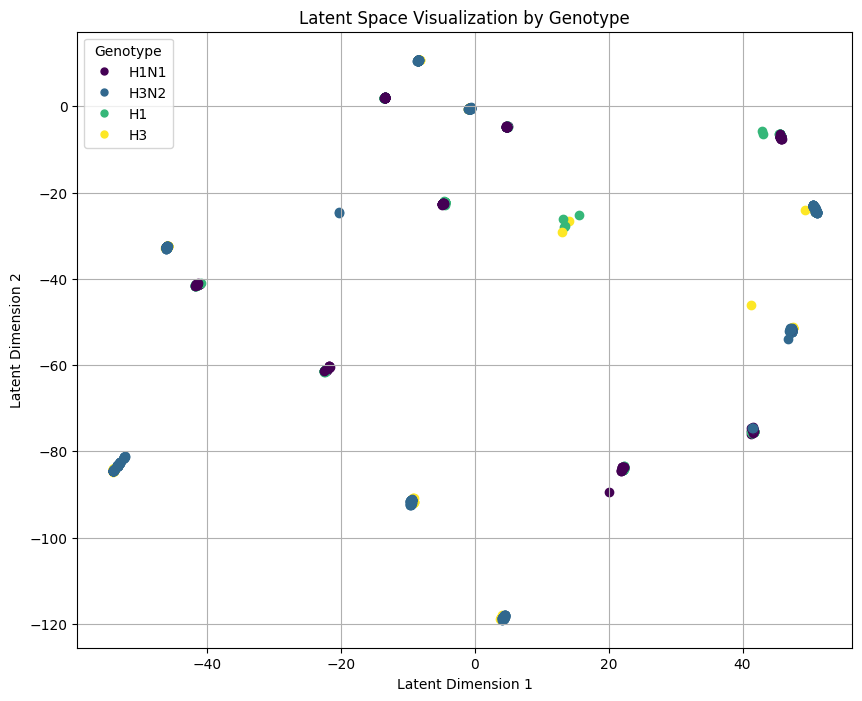

In [61]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Get unique genotypes and assign a color to each
unique_genotypes = df['Genotype'].unique()
colors = cm.get_cmap('viridis', len(unique_genotypes)) # Using viridis colormap

# Create a dictionary to map genotypes to colors
genotype_color_map = {genotype: colors(i) for i, genotype in enumerate(unique_genotypes)}

# Prepare color list for scatter plot based on genotype
point_colors = [genotype_color_map[genotype] for genotype in df['Genotype']]


plt.figure(figsize=(10, 8))
for i in range(len(df)):
  plt.scatter(df['Latent'].iloc[i][0], df['Latent'].iloc[i][1], color=point_colors[i], label=df['Genotype'].iloc[i] if i < len(unique_genotypes) else "") # Use 'color' with mapped colors

# Create a legend
handles = [plt.Line2D([], [], marker='o', color=genotype_color_map[genotype], linestyle='None', markersize=5, label=genotype) for genotype in unique_genotypes]
plt.legend(handles=handles, title="Genotype")


plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization by Genotype')
plt.grid(True)
plt.show()

In [63]:
r0 = pd.read_excel('/content/R0 data (3).xlsx', sheet_name= 'gp hours')